<a href="https://colab.research.google.com/github/r553/EDSA_Classification_Hackathon_RM/blob/master/Xente_Fraud_Challenge_RethabileM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing the libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import MultinomialNB


class color:
     BOLD = '\033[1m'
     UNDERLINE = '\033[4m'
     END = '\033[0m'
        
import warnings
warnings.filterwarnings("ignore")

# 2.Importing the datasets

In [0]:
train= pd.read_csv('training.csv')
test= pd.read_csv('test.csv')

In [0]:
sample=pd.read_csv('sample_submission.csv')

In [0]:
Var_definitions= pd.read_csv('Xente_Variable_Definitions.csv')

### 2.1. Creating copies of the datasets  

In [0]:
train_original=train.copy() 
test_original=test.copy()

# Data Description
Here's a brief description of the columns in our dataset.

In [0]:
Var_definitions

,Column Name,Definition
0,TransactionId,Unique �transaction identifier on platform
1,BatchId,Unique number assigned to a batch of transacti...
2,AccountId,Unique number identifying the customer on plat...
3,SubscriptionId,Unique number identifying the customer subscri...
4,CustomerId,Unique identifier attached to Account
5,CurrencyCode,Country currency
6,CountryCode,Numerical geographical code of country
7,ProviderId,Source provider of Item �bought.
8,ProductId,Item name being bought.
9,ProductCategory,ProductIds are organized into these broader pr...


# 3.Exploring the datasets

### 3.1. Train dataset   

In [0]:
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [0]:
train.shape

(95662, 16)

We have `95 662` rows and `16` columns 

In [0]:
train.describe()

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
TransactionId           95662 non-null object
BatchId                 95662 non-null object
AccountId               95662 non-null object
SubscriptionId          95662 non-null object
CustomerId              95662 non-null object
CurrencyCode            95662 non-null object
CountryCode             95662 non-null int64
ProviderId              95662 non-null object
ProductId               95662 non-null object
ProductCategory         95662 non-null object
ChannelId               95662 non-null object
Amount                  95662 non-null float64
Value                   95662 non-null int64
TransactionStartTime    95662 non-null object
PricingStrategy         95662 non-null int64
FraudResult             95662 non-null int64
dtypes: float64(1), int64(4), object(11)
memory usage: 11.7+ MB


We have 1 float column, 11 object columns and 4 int columns.
The float and objects columns will be encoded accordingly later on.

Lets look at how our target varible is structured

In [0]:
train_val_count=train.FraudResult.value_counts()
train_val_count

0    95469
1      193
Name: FraudResult, dtype: int64

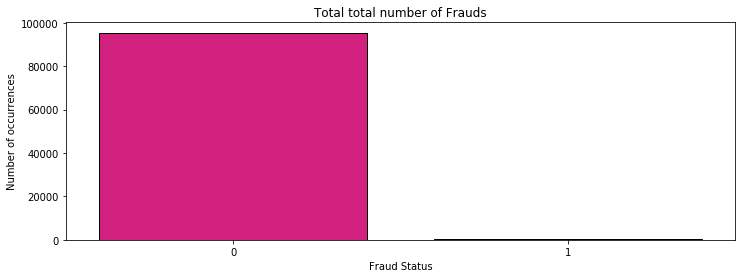

In [0]:
plt.figure(figsize=(12,4))

sns.barplot(train_val_count.index, train_val_count.values,palette= 'Accent_r', ec='black' )


plt.ylabel('Number of occurrences', fontsize=10)
plt.xlabel('Fraud Status', fontsize=10)
plt.title('Total total number of Frauds')
plt.show()

The above plot shows that we have less fraud status of transaction `1-yes` and more fraud status transactions of `0-No`.

The dataset is indeed imbalanced, and shall dealt with at a later stage as well.


#### Skewness of the target variable
Next, we’ll check for skewness, which is a measure of the shape of the distribution of values.


Skew is : 22.196 


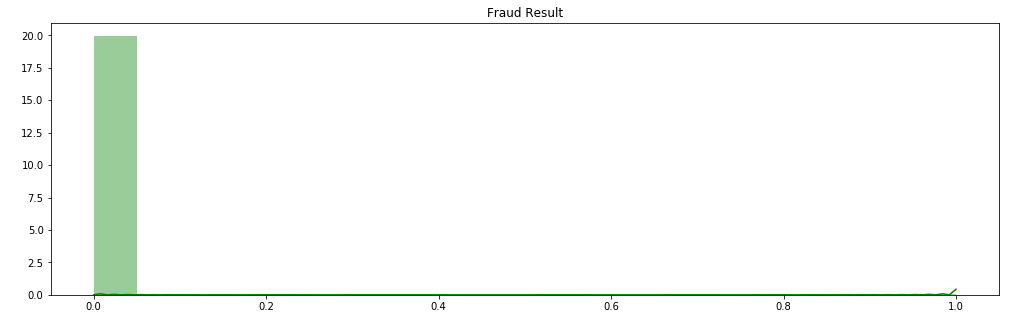

In [0]:
y_skewness=round(train.FraudResult.skew(),3)

plt.figure(figsize=(17, 5))
sns.distplot(train.FraudResult,bins=20, color='green')
plt.title('Fraud Result')
plt.xlabel(" ")
plt.ylabel(" ")
print(color.BOLD + 'Skew is :',y_skewness , color.END)
plt.show()

The above histogram plot shows the distribution of the target variable `FraudResult` as being right-skewed. The distribution has a longer tail on the right. 

Therefore the distribution of FraudResult is positively skewed, meaning that the mass of the distribution is concentrated on the left of the figure.


In [0]:
train.isnull().sum()

TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
FraudResult             0
dtype: int64

We do not have null values

### Correlation Analysis
Now that we are aware of the structure of the dataset, let us take a closer look at the dataset to analyze the features. This brings us to the next step, correlation analysis.
Here we will explore the correlation between the features and the target by plotting a correlation matrix.

In [0]:
def correlation_matrix(train):
    corr = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(corr, vmax=1.0, center=0, fmt='.2f',square=True, linewidths=.5, annot=True)
    plt.show();
    


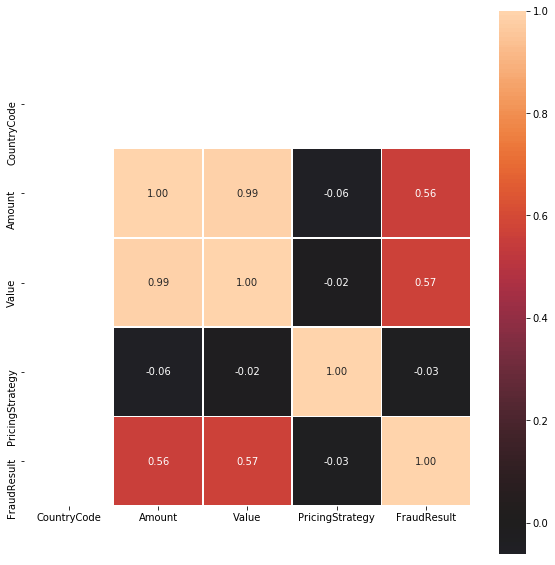

In [0]:
correlation_matrix(train)

From the above heatmap, we can see that the following features are positively correlated with the target variable(FraudResult):
- Amount - 0.56
- Value - 0.57

Moreover, the following features are correlated with each other:
- Amount and Value- 0.99

And lastly CountryCode and Pricing Strategy features are not correlated with the target variable.



### 3.2. Test dataset

In [0]:
test.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13T10:01:40Z,4
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13T10:02:12Z,2
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13T10:02:30Z,2
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13T10:02:38Z,4
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13T10:02:58Z,2


In [0]:
test.shape

(45019, 15)

The test has `45 019` rows and `15` columns , while train has `16` columns.

And this is due to the fact that the test data doesnt include the final Fraud Result information.

In [0]:
test.describe()

,CountryCode,Amount,Value,PricingStrategy
count,45019.0,4.501900e+04,4.501900e+04,45019.000000
mean,256.0,4.632681e+03,1.030034e+04,2.260646
std,0.0,9.613215e+04,9.571010e+04,0.739666
min,256.0,-2.500000e+06,2.000000e+00,0.000000
25%,256.0,-5.000000e+01,5.000000e+02,2.000000
50%,256.0,1.000000e+03,1.200000e+03,2.000000
75%,256.0,5.000000e+03,5.200000e+03,2.000000
max,256.0,9.500000e+06,9.500000e+06,4.000000


In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45019 entries, 0 to 45018
Data columns (total 15 columns):
TransactionId           45019 non-null object
BatchId                 45019 non-null object
AccountId               45019 non-null object
SubscriptionId          45019 non-null object
CustomerId              45019 non-null object
CurrencyCode            45019 non-null object
CountryCode             45019 non-null int64
ProviderId              45019 non-null object
ProductId               45019 non-null object
ProductCategory         45019 non-null object
ChannelId               45019 non-null object
Amount                  45019 non-null float64
Value                   45019 non-null int64
TransactionStartTime    45019 non-null object
PricingStrategy         45019 non-null int64
dtypes: float64(1), int64(3), object(11)
memory usage: 5.2+ MB


We also dont have null values in the test set.

And anything done the train dataset will also be done to the test datasets.

# 4. Creating X and y variables

### Train

In [0]:
train.head(2)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0


In [0]:
train[['Amount','Value']].head()

,Amount,Value
0,1000.0,1000
1,-20.0,20
2,500.0,500
3,20000.0,21800
4,-644.0,644


In [0]:
train['ProductCategory'].value_counts()

financial_services    45405
airtime               45027
utility_bill           1920
data_bundles           1613
tv                     1279
ticket                  216
movies                  175
transport                25
other                     2
Name: ProductCategory, dtype: int64

In [0]:
train.CurrencyCode.value_counts()

UGX    95662
Name: CurrencyCode, dtype: int64

In [0]:
train.ChannelId.value_counts()

ChannelId_3    56935
ChannelId_2    37141
ChannelId_5     1048
ChannelId_1      538
Name: ChannelId, dtype: int64

In [0]:
train.ProviderId.value_counts()

ProviderId_4    38189
ProviderId_6    34186
ProviderId_5    14542
ProviderId_1     5643
ProviderId_3     3084
ProviderId_2       18
Name: ProviderId, dtype: int64

In [0]:
train.ProductId.value_counts()

ProductId_6     32635
ProductId_3     24344
ProductId_10    15384
ProductId_15    11964
ProductId_1      2885
ProductId_4      2403
ProductId_21     1512
ProductId_11     1377
ProductId_19      965
ProductId_14      789
ProductId_13      296
ProductId_2       236
ProductId_20      216
ProductId_8       197
ProductId_24      175
ProductId_22      112
ProductId_7        86
ProductId_27       31
ProductId_5        25
ProductId_9        17
ProductId_16       10
ProductId_12        2
ProductId_23        1
Name: ProductId, dtype: int64

In [0]:
len(train.ProductId.value_counts())

23

In [0]:
train.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')

# X Variable- Train
For the X variable, some columns will be dropped as they do not add value.

In [0]:
X= train.drop(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId','CurrencyCode','ProviderId', 'ProductId','ChannelId','TransactionStartTime','FraudResult'], axis=1)

In [0]:
X.head()

,CountryCode,ProductCategory,Amount,Value,PricingStrategy
0,256,airtime,1000.0,1000,2
1,256,financial_services,-20.0,20,2
2,256,airtime,500.0,500,2
3,256,utility_bill,20000.0,21800,2
4,256,financial_services,-644.0,644,2


In [0]:
y= train.FraudResult

In [0]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: FraudResult, dtype: int64

In [0]:
X.shape

(95662, 5)

## Test
The above columns removed in the train set have to be removed in the test set as well.

In [0]:
test.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13T10:01:40Z,4
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13T10:02:12Z,2
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13T10:02:30Z,2
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13T10:02:38Z,4
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13T10:02:58Z,2


In [0]:
test= test.drop(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId','CurrencyCode','ProviderId', 'ProductId','ChannelId','TransactionStartTime'], axis=1)

In [0]:
test.head()

,CountryCode,ProductCategory,Amount,Value,PricingStrategy
0,256,airtime,1000.0,1000,4
1,256,financial_services,2000.0,2000,2
2,256,financial_services,-50.0,50,2
3,256,airtime,3000.0,3000,4
4,256,financial_services,-60.0,60,2


In [0]:
test.shape

(45019, 5)

# 5. Getting dummie variables
Here,we are just transforming the categorical features to numerical.

In [0]:
X=pd.get_dummies(X)  
test=pd.get_dummies(test)

In [0]:
X.head()

,CountryCode,Amount,Value,PricingStrategy,ProductCategory_airtime,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill
0,256,1000.0,1000,2,1,0,0,0,0,0,0,0,0
1,256,-20.0,20,2,0,0,1,0,0,0,0,0,0
2,256,500.0,500,2,1,0,0,0,0,0,0,0,0
3,256,20000.0,21800,2,0,0,0,0,0,0,0,0,1
4,256,-644.0,644,2,0,0,1,0,0,0,0,0,0


In [0]:
X.shape

(95662, 13)

In [0]:
test.head()

,CountryCode,Amount,Value,PricingStrategy,ProductCategory_airtime,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_retail,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill
0,256,1000.0,1000,4,1,0,0,0,0,0,0,0,0
1,256,2000.0,2000,2,0,0,1,0,0,0,0,0,0
2,256,-50.0,50,2,0,0,1,0,0,0,0,0,0
3,256,3000.0,3000,4,1,0,0,0,0,0,0,0,0
4,256,-60.0,60,2,0,0,1,0,0,0,0,0,0


In [0]:
test.shape

(45019, 13)

# 6.Building the models

# **Logistic** Regression

### 6.1. Train Splits

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size =0.2)

### 6.2. Model object and fitting

In [0]:
model_LR = LogisticRegression(C=5).fit(x_train, y_train)

pred_train_lr = model_LR.predict(x_train)



In [0]:
pred_test_lr= model_LR.predict(x_test)

In [0]:
print('Training set')
print(metrics.accuracy_score(y_train, pred_train_lr),'\n')
print(metrics.f1_score(y_train, pred_train_lr),'\n')
print(metrics.precision_score(y_train, pred_train_lr),'\n')
print(metrics.recall_score(y_train, pred_train_lr))

Training set
0.9979354231729148 

0.427536231884058 

0.5462962962962963 

0.35119047619047616


In [0]:
print('Testing set')
print(metrics.accuracy_score(y_test, pred_test_lr),'\n')
print(metrics.f1_score(y_test, pred_test_lr),'\n')
print(metrics.precision_score(y_test, pred_test_lr),'\n')
print(metrics.recall_score(y_test, pred_test_lr))

Testing set
0.998641091308211 

0.38095238095238104 

0.47058823529411764 

0.32


So our predictions are  99% accurate, i.e. we have identified 99% of the fraud status correctly.But this shows that the data overfitted

In [0]:
#train

labels = ['Not Fraud', 'Fraud']

pd.DataFrame(data=metrics.confusion_matrix(y_train, pred_train_lr), index=labels, columns=labels)


,Not Fraud,Fraud
Not Fraud,76312,49
Fraud,109,59


In [0]:
#test

pd.DataFrame(data=metrics.confusion_matrix(y_test, pred_test_lr), index=labels, columns=labels)


,Not Fraud,Fraud
Not Fraud,19099,9
Fraud,17,8


In [0]:
print('Classification Report')
print(metrics.classification_report(y_test, pred_test_lr, target_names=['Not Fraud', 'Fraud']))

Classification Report
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     19108
       Fraud       0.47      0.32      0.38        25

    accuracy                           1.00     19133
   macro avg       0.73      0.66      0.69     19133
weighted avg       1.00      1.00      1.00     19133



Our precision is 47% on  fraud. Our recall and f1_score are very low which is bad. This may be caused by the fact that we have imbalaced data.

# 7.Test dataset predictions 

In [0]:
test.head(2)

,CountryCode,Amount,Value,PricingStrategy,ProductCategory_airtime,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_retail,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill
0,256,1000.0,1000,4,1,0,0,0,0,0,0,0,0
1,256,2000.0,2000,2,0,0,1,0,0,0,0,0,0


In [0]:
pred_test_log = model_LR.predict(test)

In [0]:
pred_test_log

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
len(pred_test_log)


45019

# 8. Producing the results(csv)

In [0]:
sample.head()

,TransactionId,FraudResult
0,TransactionId_50600,NaN
1,TransactionId_95109,NaN
2,TransactionId_47357,NaN
3,TransactionId_28185,NaN
4,TransactionId_22140,NaN


In [0]:
test_original['FraudResult']= pred_test_log

In [0]:
test_original.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13T10:01:40Z,4,0
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13T10:02:12Z,2,0
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13T10:02:30Z,2,0
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13T10:02:38Z,4,0
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13T10:02:58Z,2,0


In [0]:
log1_df= pd.DataFrame({'TransactionId':test_original['TransactionId'],'FraudResult':test_original['FraudResult']})

In [0]:
log1_df.to_csv('LogisticReg1.csv', index=False)

# 9. Using another class to build the Model

# Random Forest

In [0]:
random = RandomForestClassifier(n_estimators=10).fit(x_train, y_train)
random_pred = random.predict(x_test)


In [0]:
print(metrics.accuracy_score(y_test, random_pred),'\n')
print(metrics.f1_score(y_test, random_pred),'\n')
print(metrics.precision_score(y_test, random_pred),'\n')
print(metrics.recall_score(y_test, random_pred))

0.9997909371243402 

0.9166666666666666 

0.9565217391304348 

0.88


# Predicting the test

In [0]:
pred_test_random= random.predict(test)

# Saving file

In [0]:
test_original['FraudResult']= pred_test_random

In [0]:
ran1_df= pd.DataFrame({'TransactionId':test_original['TransactionId'],'FraudResult':test_original['FraudResult']})

In [0]:
ran1_df.to_csv('RandomF1.csv', index=False)

***

# Results

The Logistic Regression model gave me a score of 0.528301886792453

And the Random Forest gave me a score of 0.679245283018868.

Showing the Random Forest model much better than the Logistic Regression model.

Surely by balancing the data, the score would have improved.